<a href="https://colab.research.google.com/github/sammyfow/cap-comp215/blob/2024.01/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Six Degrees of Watts and Strogatz
Name: Sam Fowler

Start Date: 02/05/2024

End Date: 03/04/2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque as dq
from timeit import timeit

# Generating Ring Lattice Graphs

The cell below contains all the code for generating a ring lattice graph. A ring lattice is a connected graph in which all nodes have the same number of neighbours.

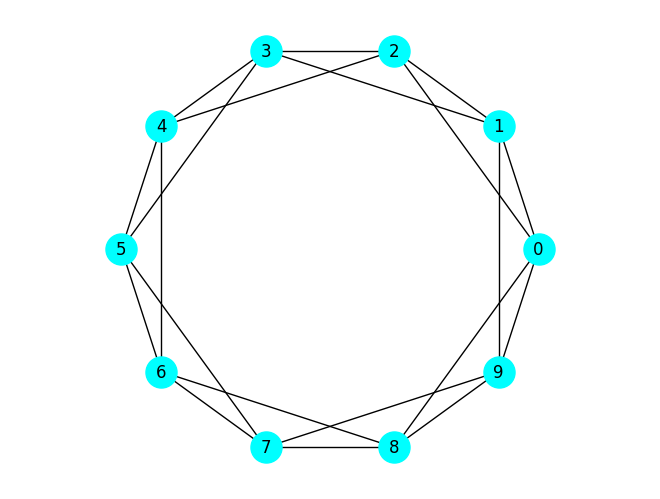

In [51]:

def better_pairs(nodes):  #from chapter 4.5 of textbook
  """Return all possible pairs as 2-tuples given a set of objects"""
  for i, u in enumerate(nodes):
    for j, v in enumerate(nodes):
      if i > j:
        yield u, v


assert set(better_pairs((0, 1, 2, 3))) == {(1, 0), (2, 0), (3, 0), (2, 1), (3, 1), (3, 2)}


def make_complete_graph(n): #from chapter 4.5 of textbook
  """Return a graph in which all nodes are connected to eachother"""
  nodes = range(n)
  graph = nx.Graph()
  graph.add_nodes_from(nodes)
  graph.add_edges_from(better_pairs(nodes))
  return graph


def adjecent_edges(n, k): #shortened version of the algorithm in chapter 5.4 of the textbook
  """Returns all edges given a number of nodes(n) and the number of neighbours(k)
  for each node. If k is odd, each node will have k-1 neighbours"""
  nodes = range(n)
  for i in nodes:
    for j in range(k // 2):
      yield i, (i + j + 1) % n


assert set(adjecent_edges(5, 2)) == {(0, 1), (1, 2), (2, 3), (3, 4), (4, 0)}
assert set(adjecent_edges(10, 5)) == set(adjecent_edges(10, 4))


def make_ring_lattice(n, k):
  """Returns a graph with n nodes and edges from adjecent_edges(n, k)"""
  g = nx.Graph()
  nodes = range(n)
  g.add_nodes_from(nodes)
  g.add_edges_from(adjecent_edges(n, k))
  return g


def draw_ring_lattice(n, k):
  """Visual representation of a ring lattice with n nodes and k neighbours"""
  nx.draw_circular(make_ring_lattice(n, k),
                   node_color='cyan',
                   node_size=500,
                   with_labels=True)
  plt.axis('equal')
  plt.show()


"""Enter some parameters to see what a ring lattice looks like"""
Nodes = int()
Neighbours = int()
draw_ring_lattice(Nodes or 10, Neighbours or 4)





# Creating Watts-Strogatz Graphs

A Watts-Strogatz graph starts with a ring lattice then each edge has a probability of being 'rewired' to a different randomly selected node.  

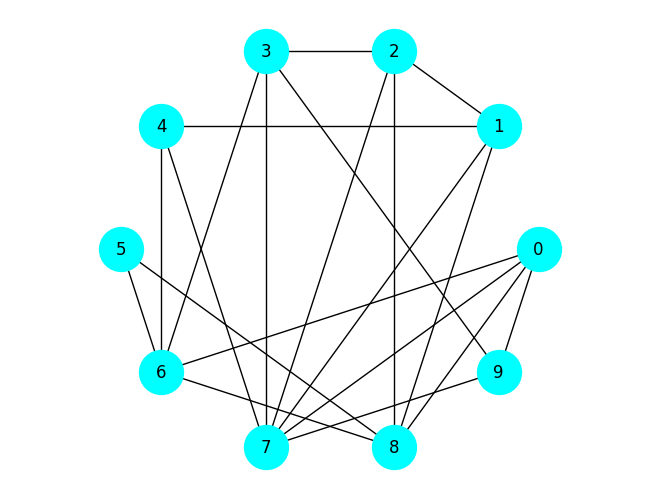

In [52]:
def rewire(G, p): #from chapter 5.5 of the textbook
  """Each edge in a graph(G) is assigned a random number(n)|0<n<1, if n<p,
  we change one of the nodes in that edge"""
  nodes = set(G)
  for a, b in G.edges():
    if np.random.random() < p:
      choices = nodes - {a} - set(G[a])
      new_b = np.random.choice(list(choices))
      G.remove_edge(a, b)
      G.add_edge(a, new_b)
  return G


def make_ws_graph(n, k, p):
  """Returns a graph object by using the rewire function on a ring lattice"""
  ws = rewire(make_ring_lattice(n, k), p)
  return ws


def draw_ws_graph(n, k, p):
  """Visual representation of a WS graph"""
  nx.draw_circular(make_ws_graph(n, k, p),
                 node_color='cyan',
                 node_size=1000,
                 with_labels=True)
  plt.axis('equal')
  plt.show()

"""Enter some parameters to see what a WS graph looks like"""
Nodes = int()
Neighbours = int()
Probability = float()
draw_ws_graph(Nodes or 10, Neighbours or 4, Probability or 0.5)





# Performing the Watts-Strogatz Experiment

The experiment is an analysis the average path length between nodes 'L', and the overall cliqueishness 'C' of WS graphs. We want to know how L and C change for a range of rewiring probabilities. We will see two different shortest path algorithms, one that employs a depth first search, and one that employs a breadth first search (shortest_path_dijkstra). In the next section we will discover that one of these algorithms is more efficient than the other.

In [53]:
def node_clustering(G, node): #from chapter 5.6 of the textbook
  """Returns the proportion of existing edges vs possible edges for a given
  node's neighbours, if a node has less than 2 neighbours, it is ignored"""
  neighbours = list(G[node])
  k = len(neighbours)
  if k < 2:
    return np.nan
  possible = k * (k - 1) / 2
  edges = 0
  for a, b in better_pairs(neighbours):
    if G.has_edge(a, b):
      edges +=1
  return edges / possible

  test = make_ring_lattice(20, 4)
  assert node_clustering(test, 0) == 0.5


def clustering_coefficient(G): #from chapter 5.6 of the textbook
  """Returns the average of each nodes clustering proportion"""
  cluster = [node_clustering(G, node) for node in list(G)]
  return np.nanmean(cluster)


def shortest_path_depth(G): #modified from chapter 5.7 of the textbook
  """Returns the average path length for all pairs of nodes. If no path
  exists, it is ignored"""
  #converted to dict from generator
  length_map = dict(nx.shortest_path_length(G))
  #ignores nodes for which no path exists to avoid NetworkXNoPath error
  lengths = [length_map[u][v] for u, v in better_pairs(G) if v in length_map[u]]
  return np.mean(lengths)


def shortest_path_dijkstra(G, source):  #from chapter 5.11 of the textbook
  """Dijkstra's single source shortest path algorithm"""
  dist = {source: 0}
  queue = dq([source])
  while queue:
    node  = queue.popleft()
    new_dist = dist[node] + 1
    neighbours = set(G[node]).difference(dist)
    for n in neighbours:
      dist[n] = new_dist
    queue.extend(neighbours)
  return dist


def mean_dijkstra(G): #written by me
  """Extends the Dijkstra algorithm to all pairs shortest path"""
  lengths = []
  seen = set()
  for node in G.nodes():
    seen.add(node)
    dists = shortest_path_dijkstra(G, node)
    for i in dists:
      if i not in seen:
        lengths.append(dists[i])
  return np.mean(lengths)


def run_single_graph_dijkstra(n, k, p):
  """Returns the clustering coefficient and mean shortest path
  for a single ws graph using the dijkstra algorithm"""
  ws = make_ws_graph(n, k, p)
  cc = clustering_coefficient(ws)
  msp = mean_dijkstra(ws)
  return cc, msp


def run_single_graph_depth(n, k, p):
  """Returns the clustering coefficient and mean shortest path
  for a single ws graph using the depth firts shortest path algorithm"""
  ws = make_ws_graph(n, k, p)
  cc = clustering_coefficient(ws)
  msp = shortest_path_depth(ws)
  return cc, msp


ps = np.logspace(-5, 0, 10)
def run_experiment_dijkstra(n, k, iters):
  """Returns an array of the results using the dijkstra algorithm for various rewiring
  propabilities"""
  results = []
  for p in ps:
    trials = [run_single_graph_dijkstra(n, k, p) for t in range(iters)]
    means = np.array(trials).mean(axis=0)
    results.append(means)
  return np.array(results)


def run_experiment_depth(n, k, iters):
  """Returns an array of the results using the depth first algorithm
  for various rewiring propabilities"""
  results = []
  for p in ps:
    trials = [run_single_graph_depth(n, k, p) for t in range(iters)]
    means = np.array(trials).mean(axis=0)
    results.append(means)
  return np.array(results)







# Timing the Experiment

Below we can see how the time to run the experiment changes as the number of nodes increases using both Dijkstra's algorithm and a depth first algorithm

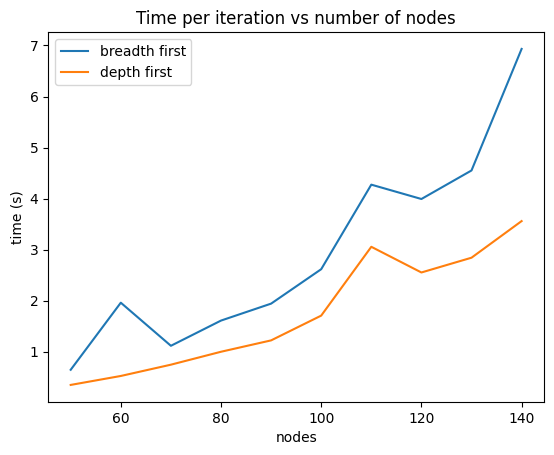

In [71]:
"""Enter an upper and lower bound for the number of nodes"""
Minimum = int()
Maximum = int()

nodes = range(Minimum or 50, Maximum or 150, 10)
timings_dijk = [timeit(lambda: run_experiment_dijkstra(node, k=node // 10, iters=1), number=10) for node in nodes]
timings_dpth = [timeit(lambda: run_experiment_depth(node, k=node // 10, iters=1), number=10) for node in nodes]
plt.plot(nodes, timings_dijk, label='breadth first')
plt.plot(nodes, timings_dpth, label='depth first')
plt.gca().set(title='Time per iteration vs number of nodes', xlabel='nodes', ylabel='time (s)')
plt.legend()
plt.show()







As we can see above, the depth first approach seems to outperform dijkstra's algorithm for every amount of nodes.

# Running the Experiment

Below we can observe how clustering coefficient and mean path length change as we increase the rewiring probability.

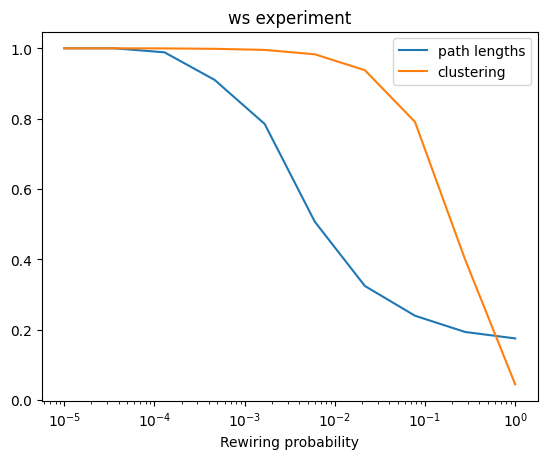

In [68]:
"""Enter some parameters to view the experiment"""  #note: n=1000, k=10 takes 15-17 seconds per iteration
Nodes = int()
Neighbours = int()
Iterations = int()

exp = run_experiment_depth(Nodes or 300, Neighbours or 10, Iterations or 20)
C, L = np.transpose(exp)
L /= L[0]
C /= C[0]


plt.plot(ps, L, label='path lengths')
plt.plot(ps, C, label='clustering')
plt.gca().set(title='ws experiment', xlabel='Rewiring probability', xscale='log')
plt.legend()
plt.show()

# What are we looking at?

The results show that for a wide range of rewiring probabilities, WS graphs maintain both high clustering and short path lengths. Much like people do. We tend to form cliques and only regularly associate with a relatively small number of people, whilst maintaining small degrees of separation from a very large number of people. This is exactly the sort of behaviour Watts and Strogatz were trying to model, the so-called 'Small World Phenomenon'.